In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp


import time
import warnings
warnings.filterwarnings("ignore")

## Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 1010


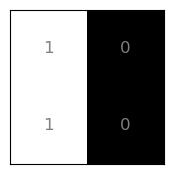

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

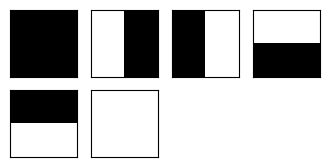

In [4]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

## Getting Wavefunction of Dataset

In [5]:
n_qubits = 4
n_ancillas = 3
total_qubits = n_qubits + n_ancillas

In [6]:
bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = torch.tensor([int(b,2) for b in bitstrings_target],dtype=torch.long)

In [7]:
wavefunctions = torch.zeros((len(nums_target),2**n_qubits), dtype=torch.float32)
wavefunctions[torch.arange(len(nums_target)),nums_target] = 1.0

dm_batch = torch.einsum("bi,bj->bij",wavefunctions,wavefunctions)
target_dm = dm_batch.mean(dim=0)

In [8]:
##### For training over the register basis
bitstrings_full_target = ['0000000','0011001','0101010','1010011','1100100','1111101']
nums_full_target = torch.tensor([int(b,2) for b in bitstrings_full_target],dtype=torch.long)

wavefunctions_full = torch.zeros((len(nums_full_target),2**total_qubits), dtype=torch.float32)
wavefunctions_full[torch.arange(len(nums_full_target)),nums_full_target] = 1.0

dm_batch_full = torch.einsum("bi,bj->bij",wavefunctions_full,wavefunctions_full)
target_dm_full = dm_batch_full.mean(dim=0)

## Functions

In [9]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss


In [10]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,interface="torch")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [11]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    px_dm = qml.math.dm_from_state_vector(px)

    return -1*qml.math.fidelity(px_dm,py) 

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    return fid_loss.real

## Training the Model

In [12]:
initial_params = torch.rand((folds, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

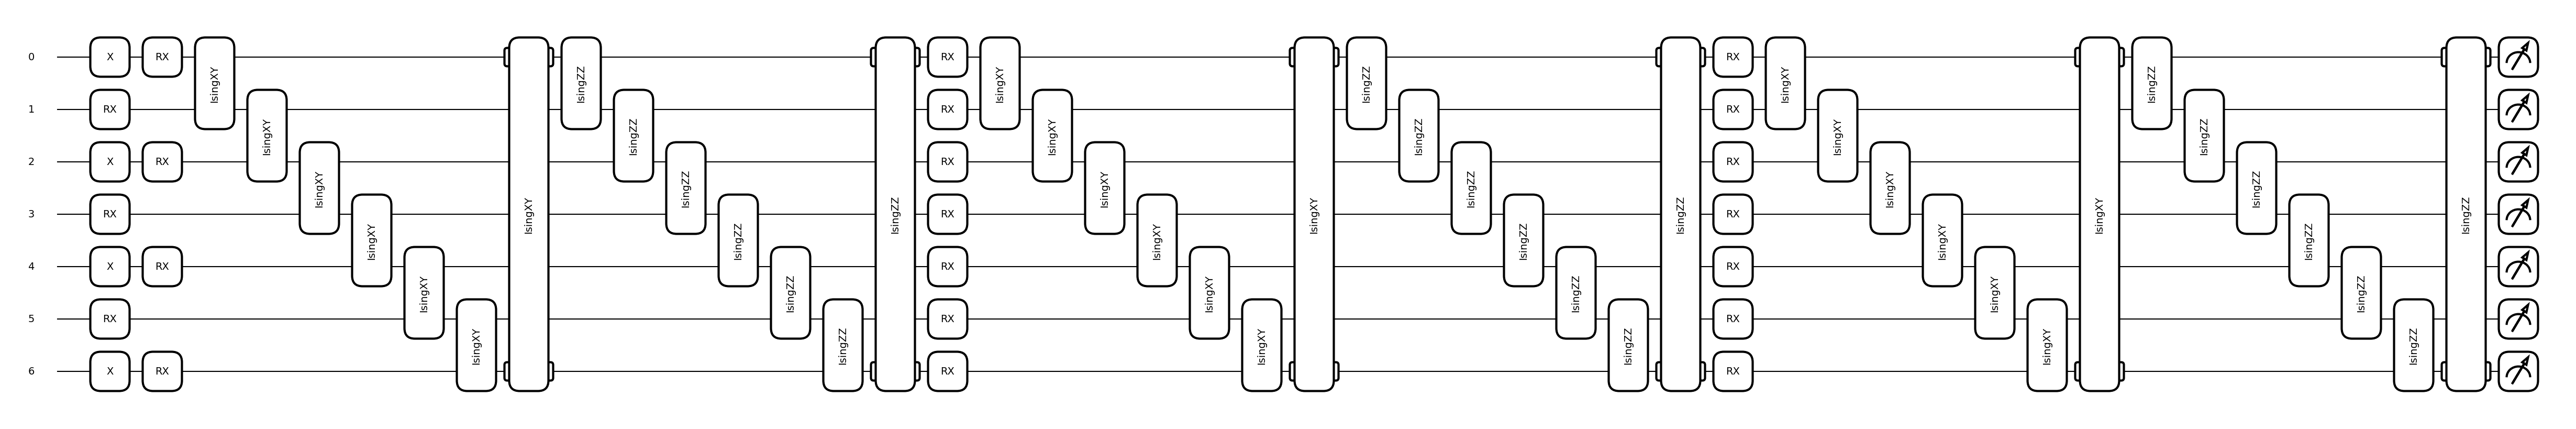

In [13]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [14]:
weights = initial_params
lr = 0.1
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds, 3* total_qubits), dtype=torch.float32)
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.11627155733869354 Time taken per iter: 0.009563922882080078
Step: 20 Loss: 0.07463756518867284 Time taken per iter: 0.009246110916137695
Step: 30 Loss: 0.059129682568125265 Time taken per iter: 0.009259223937988281
Step: 40 Loss: 0.041958656473506814 Time taken per iter: 0.01005697250366211
Step: 50 Loss: 0.025262396497445737 Time taken per iter: 0.009393930435180664
Step: 60 Loss: 0.023184869789602273 Time taken per iter: 0.00935506820678711
Step: 70 Loss: 0.02193287077121388 Time taken per iter: 0.009712934494018555
Step: 80 Loss: 0.02147076186286773 Time taken per iter: 0.009178876876831055
Step: 90 Loss: 0.021094793203911392 Time taken per iter: 0.00948786735534668
Step: 100 Loss: 0.020632165418864663 Time taken per iter: 0.009356021881103516
Step: 110 Loss: 0.018622051002191727 Time taken per iter: 0.009438037872314453
Step: 120 Loss: 0.011557582832235567 Time taken per iter: 0.009567975997924805
Step: 130 Loss: 0.010971592027052633 Time taken per iter: 0.00930976

Text(0.5, 1.0, 'Loss Over Epochs')

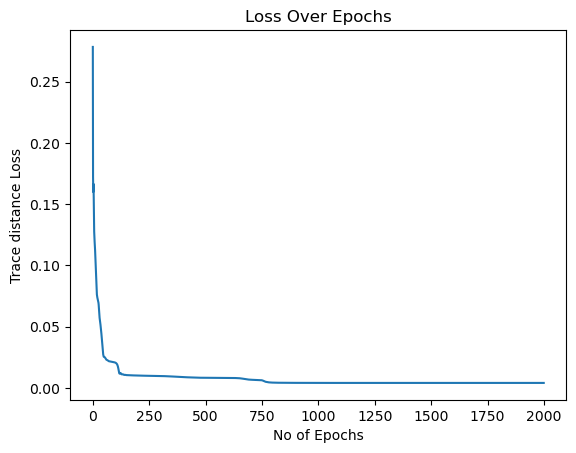

In [15]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [16]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.004009572395569068


In [17]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

In [18]:
np.round(np.diag(reduced_dm),4)

array([1.572e-01+0.j, 1.500e-03-0.j, 4.900e-03-0.j, 1.509e-01+0.j,
       3.000e-04-0.j, 1.300e-01-0.j, 2.320e-02+0.j, 1.000e-04-0.j,
       8.000e-04-0.j, 4.310e-02+0.j, 1.503e-01-0.j, 9.000e-04-0.j,
       1.577e-01+0.j, 5.500e-03+0.j, 3.000e-04-0.j, 1.731e-01+0.j])

## Training over the Register Basis

In [19]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingXY(ising_params1[-1],wires=[n_qubits+total_qubits-1,n_qubits])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[n_qubits+i,n_qubits+i+1])
    qml.IsingZZ(ising_params2[-1],wires=[n_qubits+total_qubits-1,n_qubits])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def reg_circuit(input_params,trained_params=optimal_params,folds=folds,num_qubits=n_ancillas,total_qubits=total_qubits):
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)

    for i in range(folds):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)
    
    output = qml.state()

    return output


In [20]:
reg_params = torch.rand((folds, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

(<Figure size 7000x800 with 1 Axes>, <Axes: >)

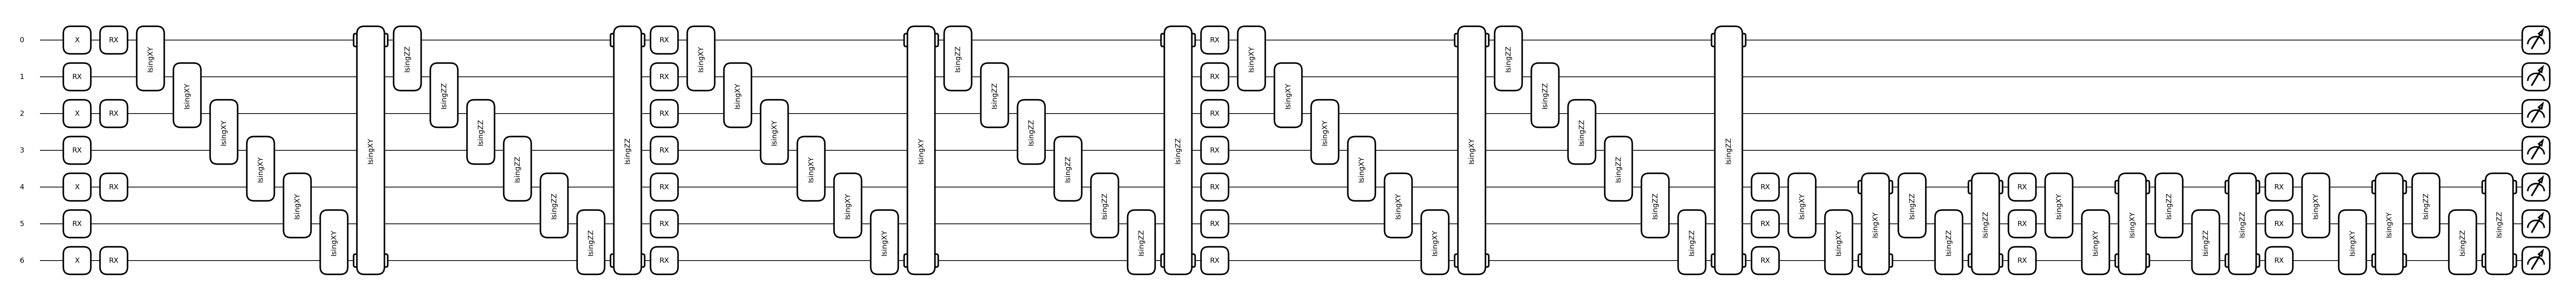

In [21]:
qml.draw_mpl(reg_circuit)(reg_params)

In [22]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.01)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds, 3 * n_ancillas), dtype=torch.float32)
min_loss = vqc(reg_circuit, weights, target_dm_full)
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss_val = vqc(reg_circuit, weights, target_dm_full)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(loss_val)

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


Step: 10 Loss: -0.0255046152336857 Time taken per iter: 0.02112603187561035
Step: 20 Loss: -0.03415166791148406 Time taken per iter: 0.020380020141601562
Step: 30 Loss: -0.042259756336980966 Time taken per iter: 0.022883176803588867
Step: 40 Loss: -0.05072887645162949 Time taken per iter: 0.02373194694519043
Step: 50 Loss: -0.06043592900968613 Time taken per iter: 0.02341008186340332
Step: 60 Loss: -0.07190206132254322 Time taken per iter: 0.022935152053833008
Step: 70 Loss: -0.08413033083497985 Time taken per iter: 0.022930145263671875
Step: 80 Loss: -0.0955252787091317 Time taken per iter: 0.021629810333251953
Step: 90 Loss: -0.1058991604794193 Time taken per iter: 0.02483391761779785
Step: 100 Loss: -0.11436476603290105 Time taken per iter: 0.022073984146118164
Step: 110 Loss: -0.12023579753213758 Time taken per iter: 0.024331092834472656
Step: 120 Loss: -0.12394104301657535 Time taken per iter: 0.022366046905517578
Step: 130 Loss: -0.12621081323699787 Time taken per iter: 0.0215833

In [23]:
full_psi = reg_circuit(optimal_reg_params)

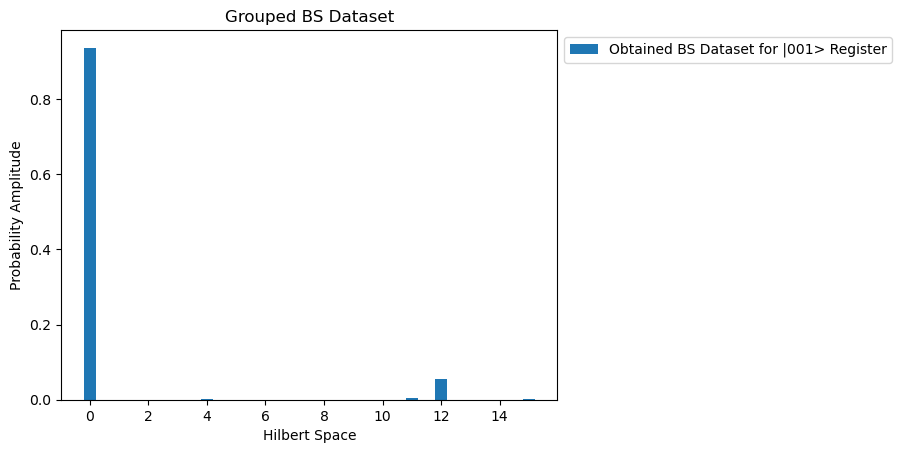

In [33]:
image = qnp.round(full_psi[::8],3)
image /= qnp.linalg.norm(image)

w, x = 0.4, np.arange(len(image))

# plt.bar(x - w/2, target_psi, w, label='Original BS Dataset')
plt.bar(x, np.abs(image)**2, w, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()